## Stability Diagnostics for Finite Difference PDE Methods

In this notebook, we explore the numerical stability of finite difference schemes for solving the Black-Scholes Partial Differential Equation (PDE). Specifically, we compare the behavior of the explicit finite difference method with the Crank-Nicolson method under coarse discretizations.

The goal is to illustrate how stability constraints affect solution quality and to emphasize why Crank-Nicolson is preferred in production-grade solvers. This diagnostic is essential for building robust PDE engines in computational finance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# Coarse grid: high dt (low M), low dx (low N) → likely to violate stability condition
S_max = 200
K = 100
T = 1
r = 0.05
sigma = 0.2

M_bad = 20   # very few time steps
N = 100      # reasonable space steps
dt_bad = T / M_bad
dS = S_max / N

S = np.linspace(0, S_max, N+1)
grid_bad_explicit = np.zeros((M_bad+1, N+1))

# Terminal condition (payoff at maturity)
grid_bad_explicit[-1] = np.maximum(S - K, 0)

# Explicit method coefficients
alpha = 0.5 * dt_bad * (sigma**2 * (np.arange(N+1))**2 - r * np.arange(N+1))
beta  = 1 - dt_bad * (sigma**2 * (np.arange(N+1))**2 + r)
gamma = 0.5 * dt_bad * (sigma**2 * (np.arange(N+1))**2 + r * np.arange(N+1))

# Backward iteration in time
for j in reversed(range(M_bad)):
    for i in range(1, N):
        grid_bad_explicit[j, i] = (alpha[i] * grid_bad_explicit[j+1, i-1]
                                   + beta[i] * grid_bad_explicit[j+1, i]
                                   + gamma[i] * grid_bad_explicit[j+1, i+1])

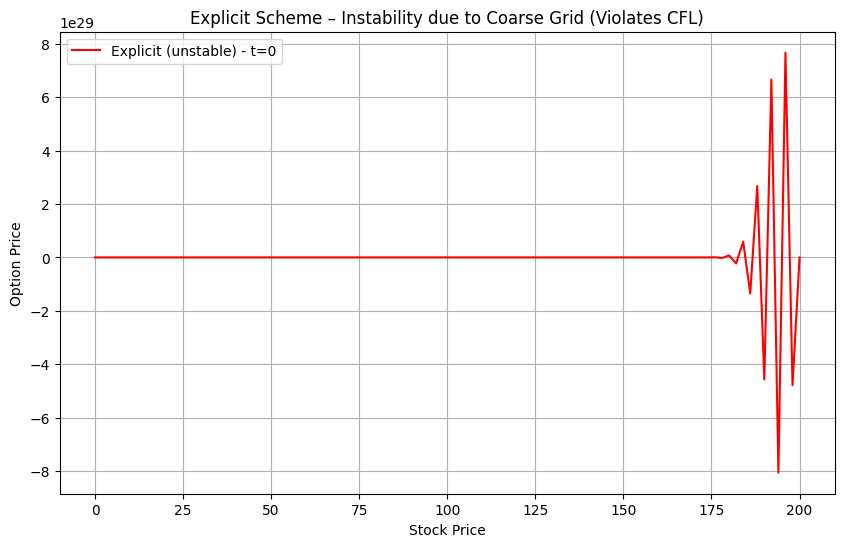

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(S, grid_bad_explicit[0], label=f'Explicit (unstable) - t=0', color='red')
plt.title("Explicit Scheme – Instability due to Coarse Grid (Violates CFL)")
plt.xlabel("Stock Price")
plt.ylabel("Option Price")
plt.grid(True)
plt.legend()
plt.show()

In [5]:
# Same grid, now Crank-Nicolson

grid_bad_cn = np.zeros((M_bad+1, N+1))
grid_bad_cn[-1] = np.maximum(S - K, 0)

# Tridiagonal matrix setup for CN
from scipy.linalg import solve_banded

def crank_nicolson_fd(M, N, T, S_max, K, r, sigma):
    dt = T / M
    dS = S_max / N
    S = np.linspace(0, S_max, N+1)

    V = np.maximum(S - K, 0)
    result = np.zeros((M+1, N+1))
    result[-1, :] = V

    # coefficients
    a = np.zeros(N-1)
    b = np.zeros(N-1)
    c = np.zeros(N-1)

    for i in range(1, N):
        Si = i * dS
        a[i-1] = 0.25 * dt * (sigma**2 * (i**2) - r * i)
        b[i-1] = -0.5 * dt * (sigma**2 * (i**2) + r) 
        c[i-1] = 0.25 * dt * (sigma**2 * (i**2) + r * i)

    A_lower = -a
    A_diag = 1 - b
    A_upper = -c
    A_banded = np.zeros((3, N-1))
    A_banded[0, 1:] = A_upper[:-1]
    A_banded[1, :] = A_diag
    A_banded[2, :-1] = A_lower[1:]

    for j in reversed(range(M)):
        rhs = np.zeros(N-1)
        for i in range(1, N):
            rhs[i-1] = a[i-1]*result[j+1, i-1] + (1 + b[i-1])*result[j+1, i] + c[i-1]*result[j+1, i+1]
        x = solve_banded((1,1), A_banded, rhs)
        result[j, 1:N] = x

    return result, S

grid_bad_cn, S = crank_nicolson_fd(M_bad, N, T, S_max, K, r, sigma)

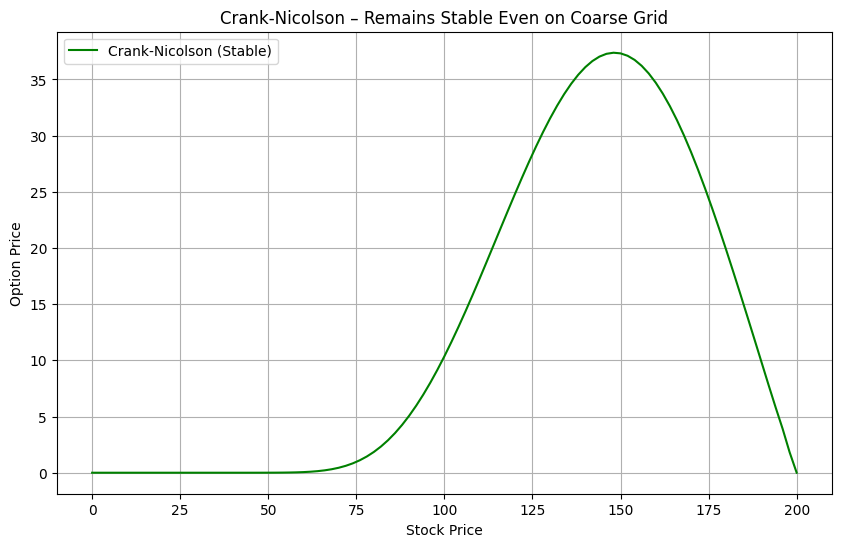

In [6]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(S, grid_bad_cn[0], label='Crank-Nicolson (Stable)', color='green')
plt.title("Crank-Nicolson – Remains Stable Even on Coarse Grid")
plt.xlabel("Stock Price")
plt.ylabel("Option Price")
plt.grid(True)
plt.legend()
plt.show()

### Summary
- The explicit method is conditionally stable. When the time step is too large relative to the space step, the solution becomes unstable and diverges.
- The Crank-Nicolson method is unconditionally stable, producing smooth and correct solutions even under coarse discretizations.
- Through visual plots, we clearly observe how numerical artifacts and oscillations emerge in the explicit method.
- This highlights the practical importance of choosing stable schemes when building real-world option pricing engines